# Week 2-3: Logistic Regression, Differential Privacy Basics


We will consider the task of binary classification where we are given labeled data $\{(x_i , y_i )\}_{i \in[n]}$
with $x_i \in \mathbb{R}^d$ and $y_i \in {−1, 1}$, and the goal is to learn a classifier $f_\theta : \mathbb{R}^d \rightarrow \{−1, 1\}$ parameterized by $\theta \in \mathbb{R}^d$ . Given a new sample $x$, our predicted label would be $\hat{y} = f_\theta (x)$. One
way to learn such a classifier is by using the logistic model defined using the conditional
probabilty


$P(y = 1|x, θ) = \frac{e^{\theta^T x}}{1+ e^{\theta^T x}}$

a) For the above model, verify that checking P(y = 1|x) > P(y = −1|x) is equivalent
to checking θ >x > 0. Given this, what would be your strategy to estimate the label
once you know θ?

**Solution:**


$$\begin{align*}
P(y = -1|x, θ) &=  1 - P(y = 1|x, θ) \\
&= 1 -\frac{e^{\theta^T x}}{1+ e^{\theta^T x}} \\
&= \frac{1}{1+ e^{\theta^T x}}
\end{align*}$$

Then
$$P(y = 1|x, θ) > P(y = -1|x, θ)$$
$$\frac{e^{\theta^T x}}{1+ e^{\theta^T x}} > \frac{1}{1+ e^{\theta^T x}}$$
$$e^{\theta^T x} > 1$$
$$\theta^T x >\ln{1}$$
$$\theta^T x > 0$$


This gives us a the intuition that for given sample $x$ we might assign a label $y=1$ if $\theta^T x > 0$ and $y=-1$ if $\theta^T x < 0$


b) Write down the log likelihood function for the above model and describe an algorithm
to find the maximum likelihood estimate for θ.

**Solution**

The maximum likelihood function is
$$\begin{align*}
\mathcal{L}(\theta) &= \prod_{y_i} P(y=1 |x,\theta) \cdot \prod_{y_i} (1 - P(y=1 |x,\theta)) \\
&= \prod P(y=1 |x,\theta)^{y_i} (1 - P(y=1 |x,\theta))^{(1-y_i)}
\end{align*}
$$

Finding the log-likelihood, we get:
$$
\begin{align*}
\mathcal{l}(\theta) &= \sum y_i \log{P(y=1 |x,\theta)} + (1-y_i) \log{1 - P(y=1 |x,\theta)} \\
&= \sum y_i \log{\frac{e^{\theta^T x}}{1+ e^{\theta^T x}}} + (1-y_i) \log{\frac{1}{1+e^{\theta^T x}}} \\
& = \sum y_i [\log{\frac{e^{\theta^T x}}{1+e^{\theta^T x}}} - \log{\frac{1}{1+e^{\theta^T x}}}] + \log{\frac{1}{1+e^{\theta^T x}}} \\
&= \sum y_i [\log{(e^{\theta^T x})} - \log{(1+e^{\theta^T x})} + \log{(1+e^{\theta^T x}}] + \log{\frac{1}{1+e^{\theta^T x}}} \\
&= \sum y_i \log{(e^{\theta^T x})} - \log{(1+e^{\theta^T x})} \\
&= \sum y_i \theta^T x - \log{(1+e^{\theta^T x})}
\end{align*}$$
For maximizing the log-likelihood function we take the derivative and find a zero:
$$\begin{align*}
\nabla_{\theta} \mathcal{l}(\theta) &= \nabla_{\theta}[\sum y_i \theta^T x_i - \log{(1+e^{\theta^T x_i})}] \\
&= \sum y_i x_i - \frac{ e^{\theta^T x}}{1+e^{\theta^T x}} x_i
\end{align*}
$$

We can find a root using gradient descent method.

In [3]:
import numpy as np

In [5]:
def log_likelihood(theta, X, y):

    linear_combination = np.dot(X, theta)

    log_ll = np.sum(y * linear_combination - np.log(1 + np.exp(linear_combination)))

    return log_ll

In [6]:
def log_likelihood_derivative(theta, X, y):

    n = len(y)
    gradient = np.zeros_like(theta)
    for i in range(n):
        linear_combination = np.dot(X[i], theta)
        gradient += (y[i]*X[i] - (( np.exp(linear_combination)/(1+ np.exp(linear_combination)))* X[i]))
    return gradient

    return derivative

In [7]:
n = 1
d = 50
X = np.random.normal(loc=0, scale=np.sqrt(0.1), size=(n,d))

theta_star = np.random.rand(d)

linear_combination = X.dot(theta_star)

probabilities = 1 / (1 + np.exp(-linear_combination))

y = np.array((np.where(probabilities >= 0.5, 1, -1)))

In [8]:
linear_combination

array([-1.12513131])

In [11]:
def gradient_descent(f, gradient, X, y, theta, learning_rate=0.001, tol=1e-6, max_iter=1000):
    for _ in range(max_iter):
        grad = gradient(theta, X, y)
        theta -= learning_rate * grad
        if np.linalg.norm(grad) < tol:
            return theta
    raise ValueError("Gradient descent did not converge within the maximum number of iterations.")

## 2. Differential Privacy Basics

### a)
- As $\epsilon$ tends to $0$, the limits of the functions $\frac{e^x}{1 + e^x}$ and $\frac{1}{1 + e^x}$ as $x$ approaches $0$ are both equal to $\frac{1}{2}$. This option leaves $y_i$ equal to $x_i$ with a probability of one half and equal to $1-x_i$ with a probability of one half. In this case, the information will remain private until the point of information loss as well.
- As $\epsilon$ tends to $\infty$, the limits of the functions $\frac{e^x}{1 + e^x}$ and $\frac{1}{1 + e^x}$ as $x$ approaches $0$ are $1$ and $0$ respectively. This scenario clearly indicates that user information becomes blatantly non-private.
- Let us use the expected value as an estimator for $y_i$, then
  $$\begin{align*}
  E[y_i] &= x_i (\frac{e^\epsilon}{1+e^\epsilon}) + (1-x_i)(\frac{1}{1+e^\epsilon}) \\
  &= \frac{x_i e^\epsilon}{1+e^\epsilon} + \frac{1-x_i}{1+e^\epsilon} \\
  &= \frac{x_i e^\epsilon + 1 - x_i}{e^\epsilon - 1} \\
  &= \frac{e^\epsilon + x_i(1-e^\epsilon)}{e^\epsilon - 1}
  \end{align*}$$
  Solving for $x_i$:
  $$\begin{align*}
  x_i &= \frac{E[y_i](1+e^\epsilon)-1}{e^\epsilon - 1} \\
  &= E\Big[\frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1}\Big]
  \end{align*}$$
  Thus, the estimator is
  $$\hat{p} = \frac{1}{n} \sum_{i=0}^{n}\frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1}$$
  Let us verify if this estimator is biased
  $$
  \begin{align*}
  E[\hat{p}] &= E \Big[ \frac{1}{n} \sum_{i=0}^{n}\frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1} \Big] \\
  &=  \frac{1}{n} \sum_{i=0}^{n} E \Big[ \frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1} \Big] \\
  &= \frac{1}{n} \sum_{i=0}^{n} x_i \\
  &= p
  \end{align*}
  $$
  Then, the estimator $\hat{p}$ is unbiased.

  Let us verify the variance for $\hat{p}$
  $$
  \begin{align*}
  Var[\hat{p}] &= Var\Big[ \frac{1}{n} \sum_{i=0}^{n}\frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1}\Big] \\
  &= \frac{1}{n^2} Var\Big[  \sum_{i=0}^{n}\frac{y_i(1+e^\epsilon)-1}{e^\epsilon - 1}\Big] \\
  &=  \frac{1}{n^2} \cdot \frac{(1+e^\epsilon)^2}{(e^\epsilon - 1)^2} Var\Big[  \sum_{i=0}^{n}y_i\Big]
  \end{align*}
  $$
  Since the variance of a Bernoulli distribution is bounded by $\frac{1}{4}$:
  $$Var[\hat{p}] = \frac{(1+e^\epsilon)^2}{n^2 (e^\epsilon - 1)^2} \cdot Var\Big[  \sum_{i=0}^{n}y_i\Big] \leq \frac{(1+e^\epsilon)^2}{4n^2 (e^\epsilon - 1)^2}$$

In [23]:
import matplotlib.pyplot as plt

<ipython-input-13-6a53a4a8c94c>:5: RuntimeWarning: divide by zero encountered in scalar divide
  vi_1 = (1+np.exp(epsilon))**2 / (4*n**2*(np.exp(epsilon) - 1)**2)
<ipython-input-13-6a53a4a8c94c>:7: RuntimeWarning: divide by zero encountered in scalar divide
  vi_2 = 1/(np.sqrt(n)*epsilon)


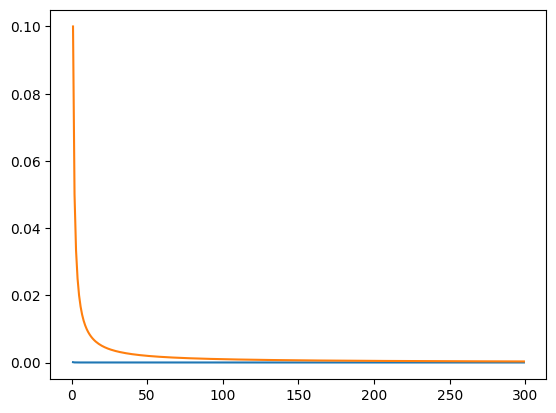

In [13]:
n = 100
variance_bound_1 = list()
variance_bound_2 = list() # 1/sqrt(n) epsilon
for epsilon in range(300):
  vi_1 = (1+np.exp(epsilon))**2 / (4*n**2*(np.exp(epsilon) - 1)**2)
  variance_bound_1.append(vi_1)
  vi_2 = 1/(np.sqrt(n)*epsilon)
  variance_bound_2.append(vi_2)
plt.plot(variance_bound_1)
plt.plot(variance_bound_2)

As epsilon increasing our bound tends to $\frac{1}{\sqrt{n}\epsilon}$

### (d) Private Gradient Descent Algorithm

In [4]:
n = 1000
d = 50
X = np.random.normal(loc=0, scale=np.sqrt(0.1), size=(n, d))
theta_star = np.random.rand(d)
y = X.dot(theta_star)

In [17]:
loc = 0
b = 1

In [18]:
def l2_loss(theta, X=X, y=y):
    predictions = np.dot(X, theta)
    error = y - predictions
    squared_loss = np.sum(error ** 2)
    l2_loss = squared_loss
    return l2_loss
    
def gradient_l2(theta, X=X, y=y):
    predictions = np.dot(X, theta)
    error = y - predictions
    grad_theta = -2 * np.dot(X.T, error)
    return grad_theta
    

In [21]:
def gradient_descent():
    n, d = X.shape
    theta = np.random.rand(d)
    k = 50
    t = 0.001
    
    # loss_track = [l2_loss(theta)]
    
    gradient_track = [np.linalg.norm(gradient_l2(theta))]
    for it in range(k):
        gradient = gradient_l2(theta)
        w = np.random.laplace(loc, b, d)
        theta = theta -  t*(gradient+w)
        
        # loss_track.append(l2_loss(theta))
        gradient_track.append(np.linalg.norm(gradient_l2(theta)))
    return gradient_track, theta

[546.5387234323287, 444.48199180291806, 362.81583356625964, 297.419698332644, 244.99894312720195, 201.84789580996437, 166.78925510382007, 138.6555224970107, 115.37955777382871, 96.37506528149343, 80.93040170613486, 67.757288346568, 56.95877545985799, 47.95396954955434, 40.10511773389911, 33.749112681571106, 29.004207647628363, 24.87603928695696, 21.203994328382482, 17.82588653957939, 15.054173070901467, 12.65314962941008, 11.140333316216903, 9.567563136745555, 8.333192730885294, 7.257587154216737, 6.566307752315046, 5.364277263554911, 4.661696979504899, 4.116579547546893, 3.8713485847806934, 3.654915564433113, 3.5266104863362036, 3.465706633360181, 3.560028767106125, 3.428053437435788, 3.346860166705034, 3.1740282401681923, 3.3960719236762706, 3.389504954459494, 3.745214202366227, 3.372093266793191, 3.320052240444742, 3.017495258761167, 3.2257049452629976, 3.515672548797286, 3.1677919148793117, 3.1153335744467565, 2.7865460490754255, 2.931838533000218, 2.6882401001532483]


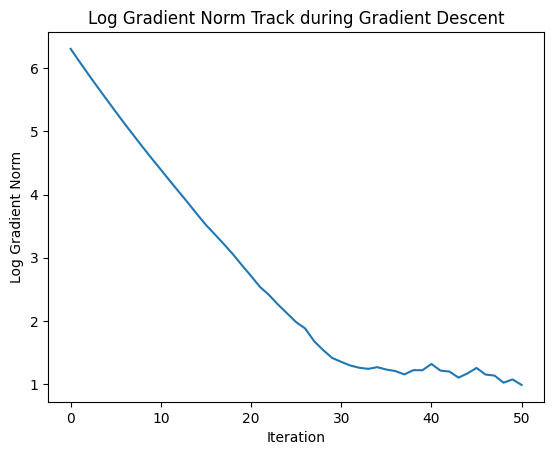

In [24]:
gradient_track, optimal_theta = gradient_descent()
print(gradient_track)

log_gradient_track = np.log(gradient_track)

plt.plot(log_gradient_track)
plt.xlabel('Iteration')
plt.ylabel('Log Gradient Norm')
plt.title('Log Gradient Norm Track during Gradient Descent')
plt.show()
